In [4]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [70]:
def read_raw_data(dir_path):
    imu = pd.DataFrame()
    imu_time = pd.DataFrame()
    y = pd.DataFrame()
    y_time = pd.DataFrame()
    for f in sorted(os.listdir(dir_path)):
            if f[-7:] == '__x.csv':
                csv_data = pd.read_csv(f'{dir_path}/{f}',
                            header=None,
                            names =['x_accel','y_accel','z_accel','x_gyro','y_gyro','z_gyro'],
                            dtype=np.float64)
                subject = int(f[-13:-10])
                trial = int(f[-9:-7])
                csv_data = csv_data.assign(subject = subject)
                csv_data = csv_data.assign(trial = trial)
                imu = pd.concat([imu, csv_data], axis=0)

            elif f[-12:] == '__x_time.csv':
                csv_data = pd.read_csv(f'{dir_path}/{f}',
                            header=None,
                            names =['x_time'],
                            dtype=np.float64)
                subject = int(f[-18:-15])
                csv_data = csv_data.assign(subject = subject)
                imu_time = pd.concat([imu_time, csv_data], axis=0)

            elif f[-7:] == '__y.csv':
                csv_data = pd.read_csv(f'{dir_path}/{f}',
                            header=None,
                            names =['y'],
                            dtype=np.int8)
                subject = int(f[-13:-10])
                trial = int(f[-9:-7])
                csv_data = csv_data.assign(subject = subject)
                csv_data = csv_data.assign(trial = trial)
                y = pd.concat([y, csv_data], axis=0)

            elif f[-12:] == '__y_time.csv':
                csv_data = pd.read_csv(f'{dir_path}/{f}',
                            header=None,
                            names =['y_time'],
                            dtype=np.float64)
                subject = int(f[-18:-15])
                csv_data = csv_data.assign(subject = subject)
                y_time = pd.concat([y_time, csv_data], axis=0)
                
    imu_data = pd.concat([imu,imu_time['x_time']], axis=1)
    y_data = pd.concat([y,y_time['y_time']],axis = 1)
    return imu_data, y_data

In [71]:
imu_data, y_data = read_raw_data('TrainingData')
df_test, dump = read_raw_data('TestData')


In [72]:
# upsamples from 10Hz to 40 Hz
y_10 = y_data['y'].to_numpy(dtype=int)
y_40 = np.empty([4*len(y_10)],dtype=int)

for i in range(0,len(y_10)):
     y_40[4*i] = y_10[i]
     y_40[4*i+1] = y_10[i]
     y_40[4*i+2] = y_10[i]
     y_40[4*i+3] = y_10[i]


In [77]:
# removes a few elements so the sizes match
print('Removing ', len(y_40)-imu_data.shape[0], ' elements from y_40')
y_40 = np.resize(y_40,(imu_data.shape[0],1))
print(imu_data.shape)
print(y_40.shape)
df = imu_data
df['y'] = y_40
#df['y'] = pd.to_numeric(df['y'],errors='coerce')
print(df['y'])
print(df.dtypes)
#print(df['y'].isna())
#df.astype({'y':'int8'})
print(df.dtypes)
df.head()

Removing  0  elements from y_40
(1341646, 10)
(1341646, 1)
0        0
1        0
2        0
3        0
4        0
        ..
48133    0
48134    0
48135    0
48136    0
48137    0
Name: y, Length: 1341646, dtype: int64
x_accel    float64
y_accel    float64
z_accel    float64
x_gyro     float64
y_gyro     float64
z_gyro     float64
subject      int64
trial        int64
x_time     float64
y            int64
dtype: object
x_accel    float64
y_accel    float64
z_accel    float64
x_gyro     float64
y_gyro     float64
z_gyro     float64
subject      int64
trial        int64
x_time     float64
y            int64
dtype: object


,x_accel,y_accel,z_accel,x_gyro,y_gyro,z_gyro,subject,trial,x_time,y
0,4.435275,8.196063,2.974488,0.014215,-0.039157,-0.016744,1,1,0.000,0
1,4.186920,8.344455,2.908057,0.005771,-0.004480,-0.003345,1,1,0.025,0
2,4.544637,8.408659,2.890000,0.007967,0.022412,0.001159,1,1,0.050,0
3,4.849308,8.411614,2.900692,0.027778,-0.010670,-0.014223,1,1,0.075,0
4,4.509190,8.118649,2.847298,0.021577,-0.045498,-0.021111,1,1,0.100,0


In [78]:
df_test.dropna(axis=0, how='any', inplace=True)
df.dropna(axis=0, how='any', inplace=True)
print(df.head())
print(df.shape)

    x_accel   y_accel   z_accel    x_gyro    y_gyro    z_gyro  subject  trial   
0  4.435275  8.196063  2.974488  0.014215 -0.039157 -0.016744        1      1  \
1  4.186920  8.344455  2.908057  0.005771 -0.004480 -0.003345        1      1   
2  4.544637  8.408659  2.890000  0.007967  0.022412  0.001159        1      1   
3  4.849308  8.411614  2.900692  0.027778 -0.010670 -0.014223        1      1   
4  4.509190  8.118649  2.847298  0.021577 -0.045498 -0.021111        1      1   

   x_time  y  
0   0.000  0  
1   0.025  0  
2   0.050  0  
3   0.075  0  
4   0.100  0  
(1341646, 10)


In [137]:
df_train = df[df['subject'] != 6 ]
df_val = df[df['subject'] == 6 ]
print(df_train.shape)

(1188830, 10)


In [138]:
from sklearn.preprocessing import RobustScaler

scale_columns = ['x_accel', 'y_accel', 'z_accel','x_gyro','y_gyro','z_gyro']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_val.loc[:, scale_columns] = scaler.transform(df_val[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

/Users/javert/.pyenv/versions/3.8.16/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/Users/javert/.pyenv/versions/3.8.16/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/Users/javert/.pyenv/versions/3.8.16/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [140]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 80
STEP = 40

X_train, y_train = create_dataset(
    df_train[scale_columns], 
    df_train['y'], 
    TIME_STEPS, 
    STEP
)

X_val, y_val = create_dataset(
    df_val[scale_columns], 
    df_val['y'], 
    TIME_STEPS, 
    STEP
)

X_test, dump = create_dataset(
    df_test[scale_columns], 
    df_test['x_accel'], 
    TIME_STEPS, 
    STEP
)

/var/folders/m_/421bzb5d0h92ss631nbbk9ym0000gn/T/ipykernel_31360/230933084.py:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
/var/folders/m_/421bzb5d0h92ss631nbbk9ym0000gn/T/ipykernel_31360/230933084.py:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False

In [141]:
print(X_train.shape, y_train.shape)

(29719, 80, 6) (29719, 1)


In [142]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_val = enc.transform(y_val)

/Users/javert/.pyenv/versions/3.8.16/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [143]:
print(X_train.shape, y_train.shape)

(29719, 80, 6) (29719, 4)


In [144]:
batch_size = 1000

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-best-f1_score.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor = 'val_f1_score',
    mode = 'max',
    save_best_only=True,
 )

In [145]:
import tensorflow_addons as tfa
f1_score = tfa.metrics.F1Score(
    num_classes = 4,
    average = 'macro',
    name = 'f1_score'
)

In [146]:
model = keras.Sequential()
model.add(keras.Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=256, 
      )
    )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',f1_score])

model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_14 (Bidirecti  (None, 512)              538624    
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 128)               65664     
                                                                 
 dense_29 (Dense)            (None, 4)                 516       
                                                                 
Total params: 604,804
Trainable params: 604,804
Non-trainable params: 0
_________________________________________________________________


In [153]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=batch_size,
    validation_data = (X_val, y_val),
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/5
30/30 [==============================] - ETA: 0s - loss: 0.5900 - acc: 0.7921 - f1_score: 0.5268
Epoch 1: val_f1_score improved from 0.45420 to 0.55364, saving model to training_2/cp-0001.ckpt


INFO:tensorflow:Assets written to: training_2/cp-0001.ckpt/assets


INFO:tensorflow:Assets written to: training_2/cp-0001.ckpt/assets


30/30 [==============================] - 34s 1s/step - loss: 0.5900 - acc: 0.7921 - f1_score: 0.5268 - val_loss: 0.4945 - val_acc: 0.8259 - val_f1_score: 0.5536
Epoch 2/5
30/30 [==============================] - ETA: 0s - loss: 0.5244 - acc: 0.8074 - f1_score: 0.6030
Epoch 2: val_f1_score improved from 0.55364 to 0.63993, saving model to training_2/cp-0002.ckpt


INFO:tensorflow:Assets written to: training_2/cp-0002.ckpt/assets


INFO:tensorflow:Assets written to: training_2/cp-0002.ckpt/assets


30/30 [==============================] - 39s 1s/step - loss: 0.5244 - acc: 0.8074 - f1_score: 0.6030 - val_loss: 0.4112 - val_acc: 0.8445 - val_f1_score: 0.6399
Epoch 3/5
30/30 [==============================] - ETA: 0s - loss: 0.5064 - acc: 0.7959 - f1_score: 0.6370
Epoch 3: val_f1_score improved from 0.63993 to 0.66418, saving model to training_2/cp-0003.ckpt


INFO:tensorflow:Assets written to: training_2/cp-0003.ckpt/assets


INFO:tensorflow:Assets written to: training_2/cp-0003.ckpt/assets


30/30 [==============================] - 77s 3s/step - loss: 0.5064 - acc: 0.7959 - f1_score: 0.6370 - val_loss: 0.4454 - val_acc: 0.8458 - val_f1_score: 0.6642
Epoch 4/5
30/30 [==============================] - ETA: 0s - loss: 0.4637 - acc: 0.8289 - f1_score: 0.6989
Epoch 4: val_f1_score did not improve from 0.66418
30/30 [==============================] - 54s 2s/step - loss: 0.4637 - acc: 0.8289 - f1_score: 0.6989 - val_loss: 0.4324 - val_acc: 0.8437 - val_f1_score: 0.6500
Epoch 5/5
30/30 [==============================] - ETA: 0s - loss: 0.4693 - acc: 0.8250 - f1_score: 0.7046
Epoch 5: val_f1_score did not improve from 0.66418
30/30 [==============================] - 53s 2s/step - loss: 0.4693 - acc: 0.8250 - f1_score: 0.7046 - val_loss: 0.4239 - val_acc: 0.8426 - val_f1_score: 0.6198


In [124]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


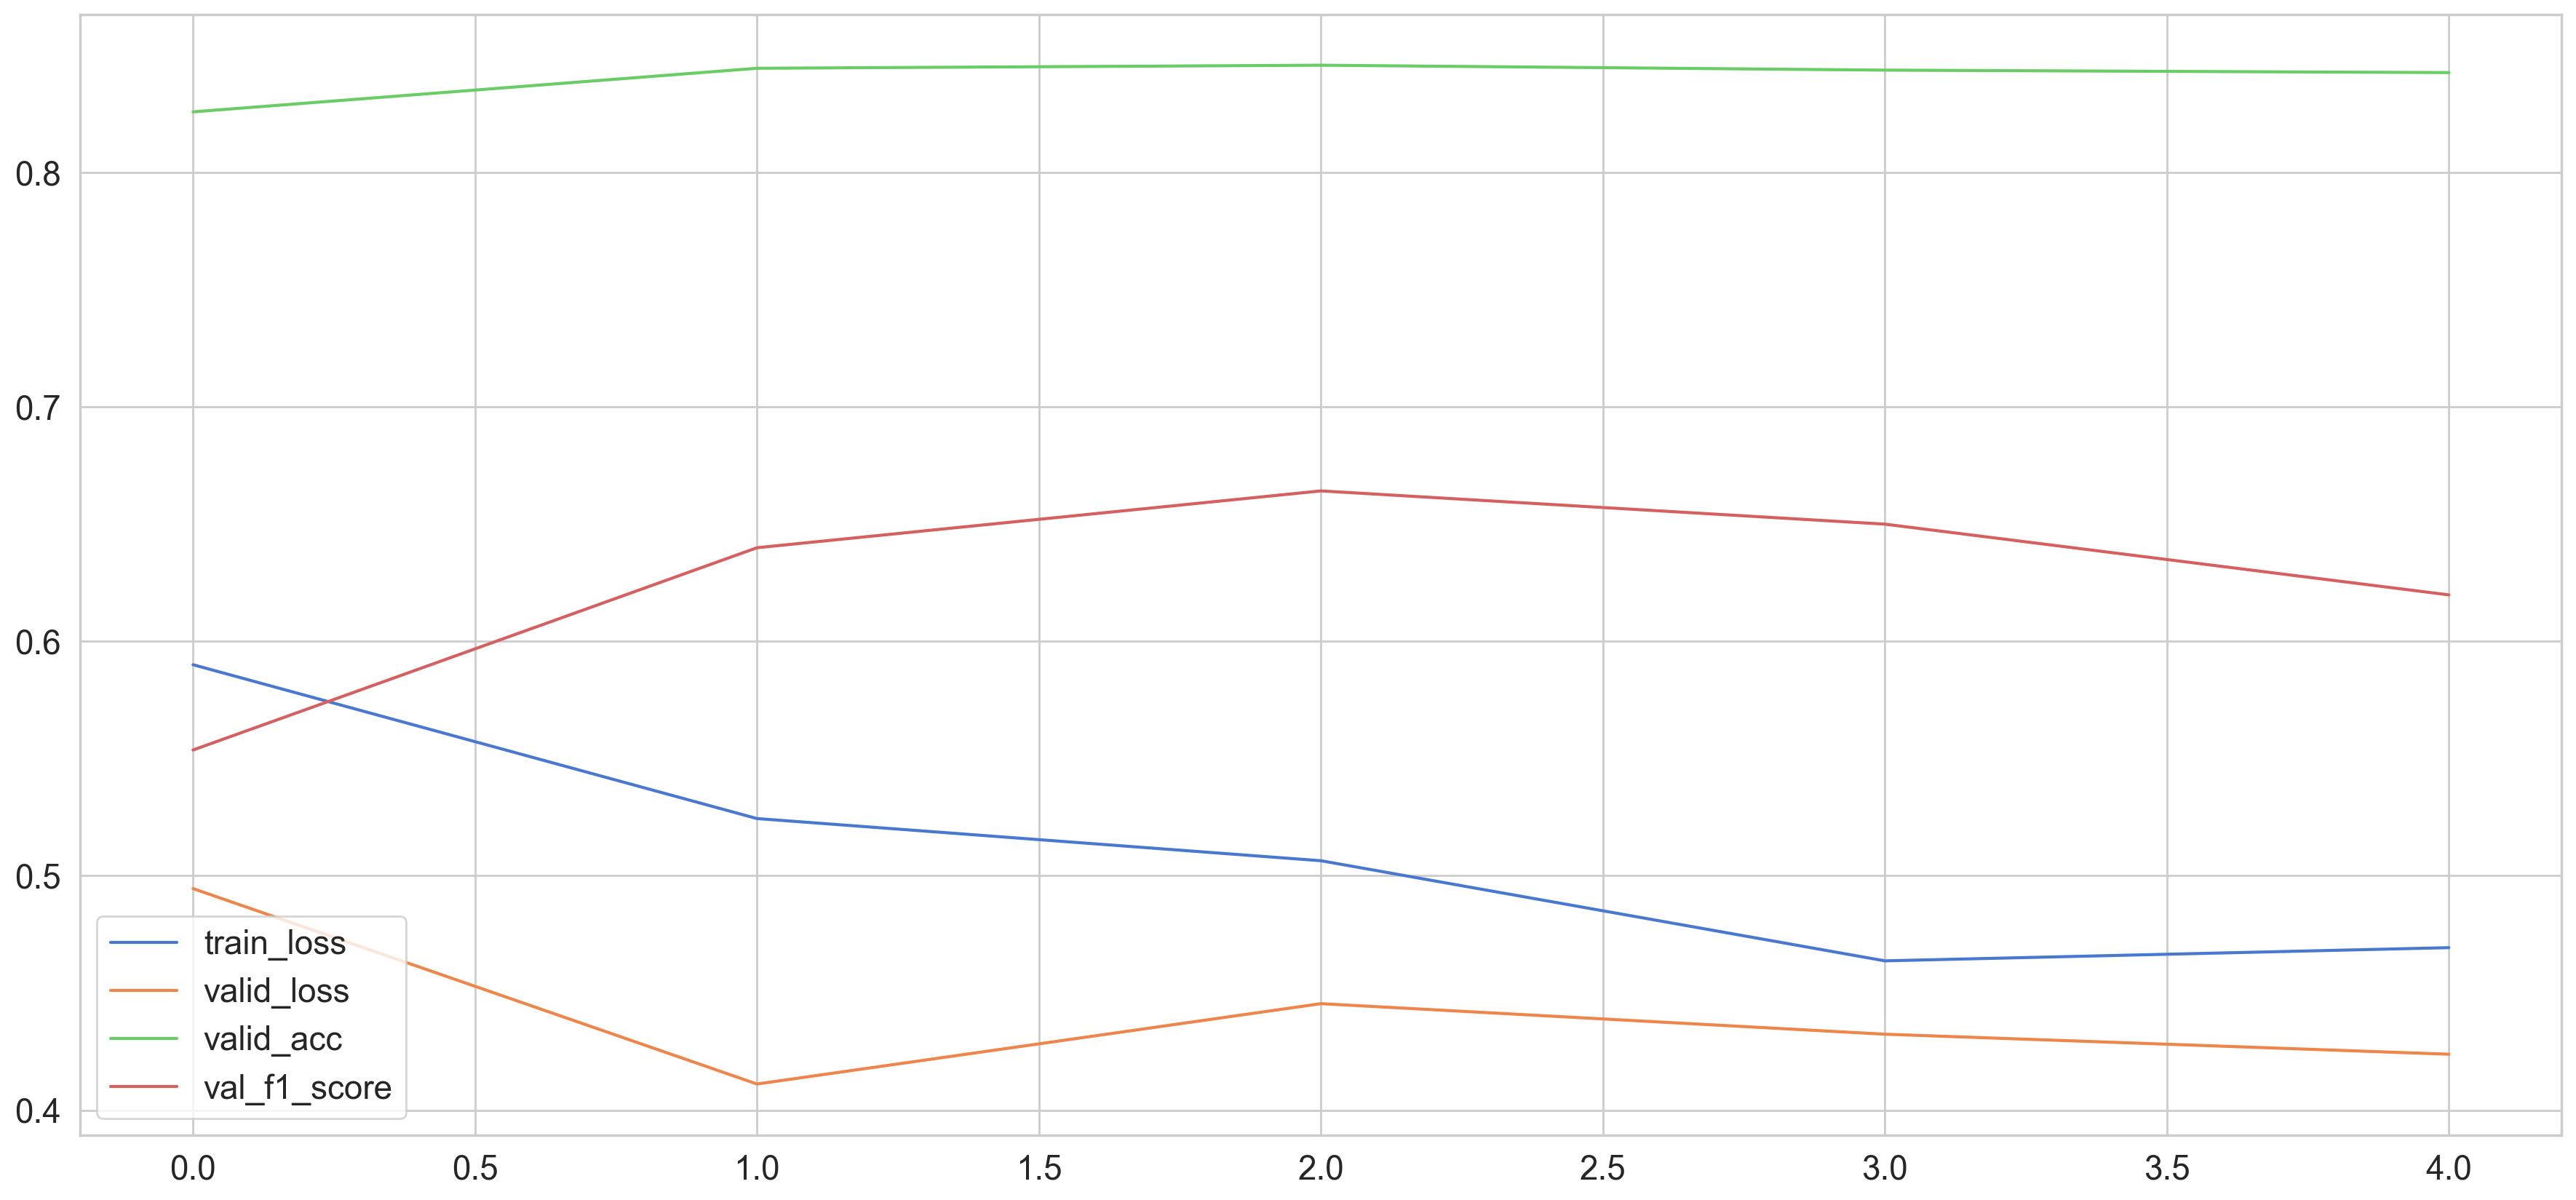

In [154]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='valid_loss')
plt.plot(history.history['val_acc'], label='valid_acc')
plt.plot(history.history['val_f1_score'], label='val_f1_score')

plt.legend();

In [155]:
model.load_weights('training_2/cp-0003.ckpt')

2023-04-16 15:22:30.574290: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open training_2/cp-0003.ckpt: FAILED_PRECONDITION: training_2/cp-0003.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [156]:
model.evaluate(X_val, y_val)

120/120 [==============================] - 3s 26ms/step - loss: 0.4454 - acc: 0.8458 - f1_score: 0.6642


[0.4454430341720581, 0.8457711338996887, 0.6641767621040344]

In [157]:
y_pred = model.predict(X_val)

120/120 [==============================] - 3s 25ms/step


In [158]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

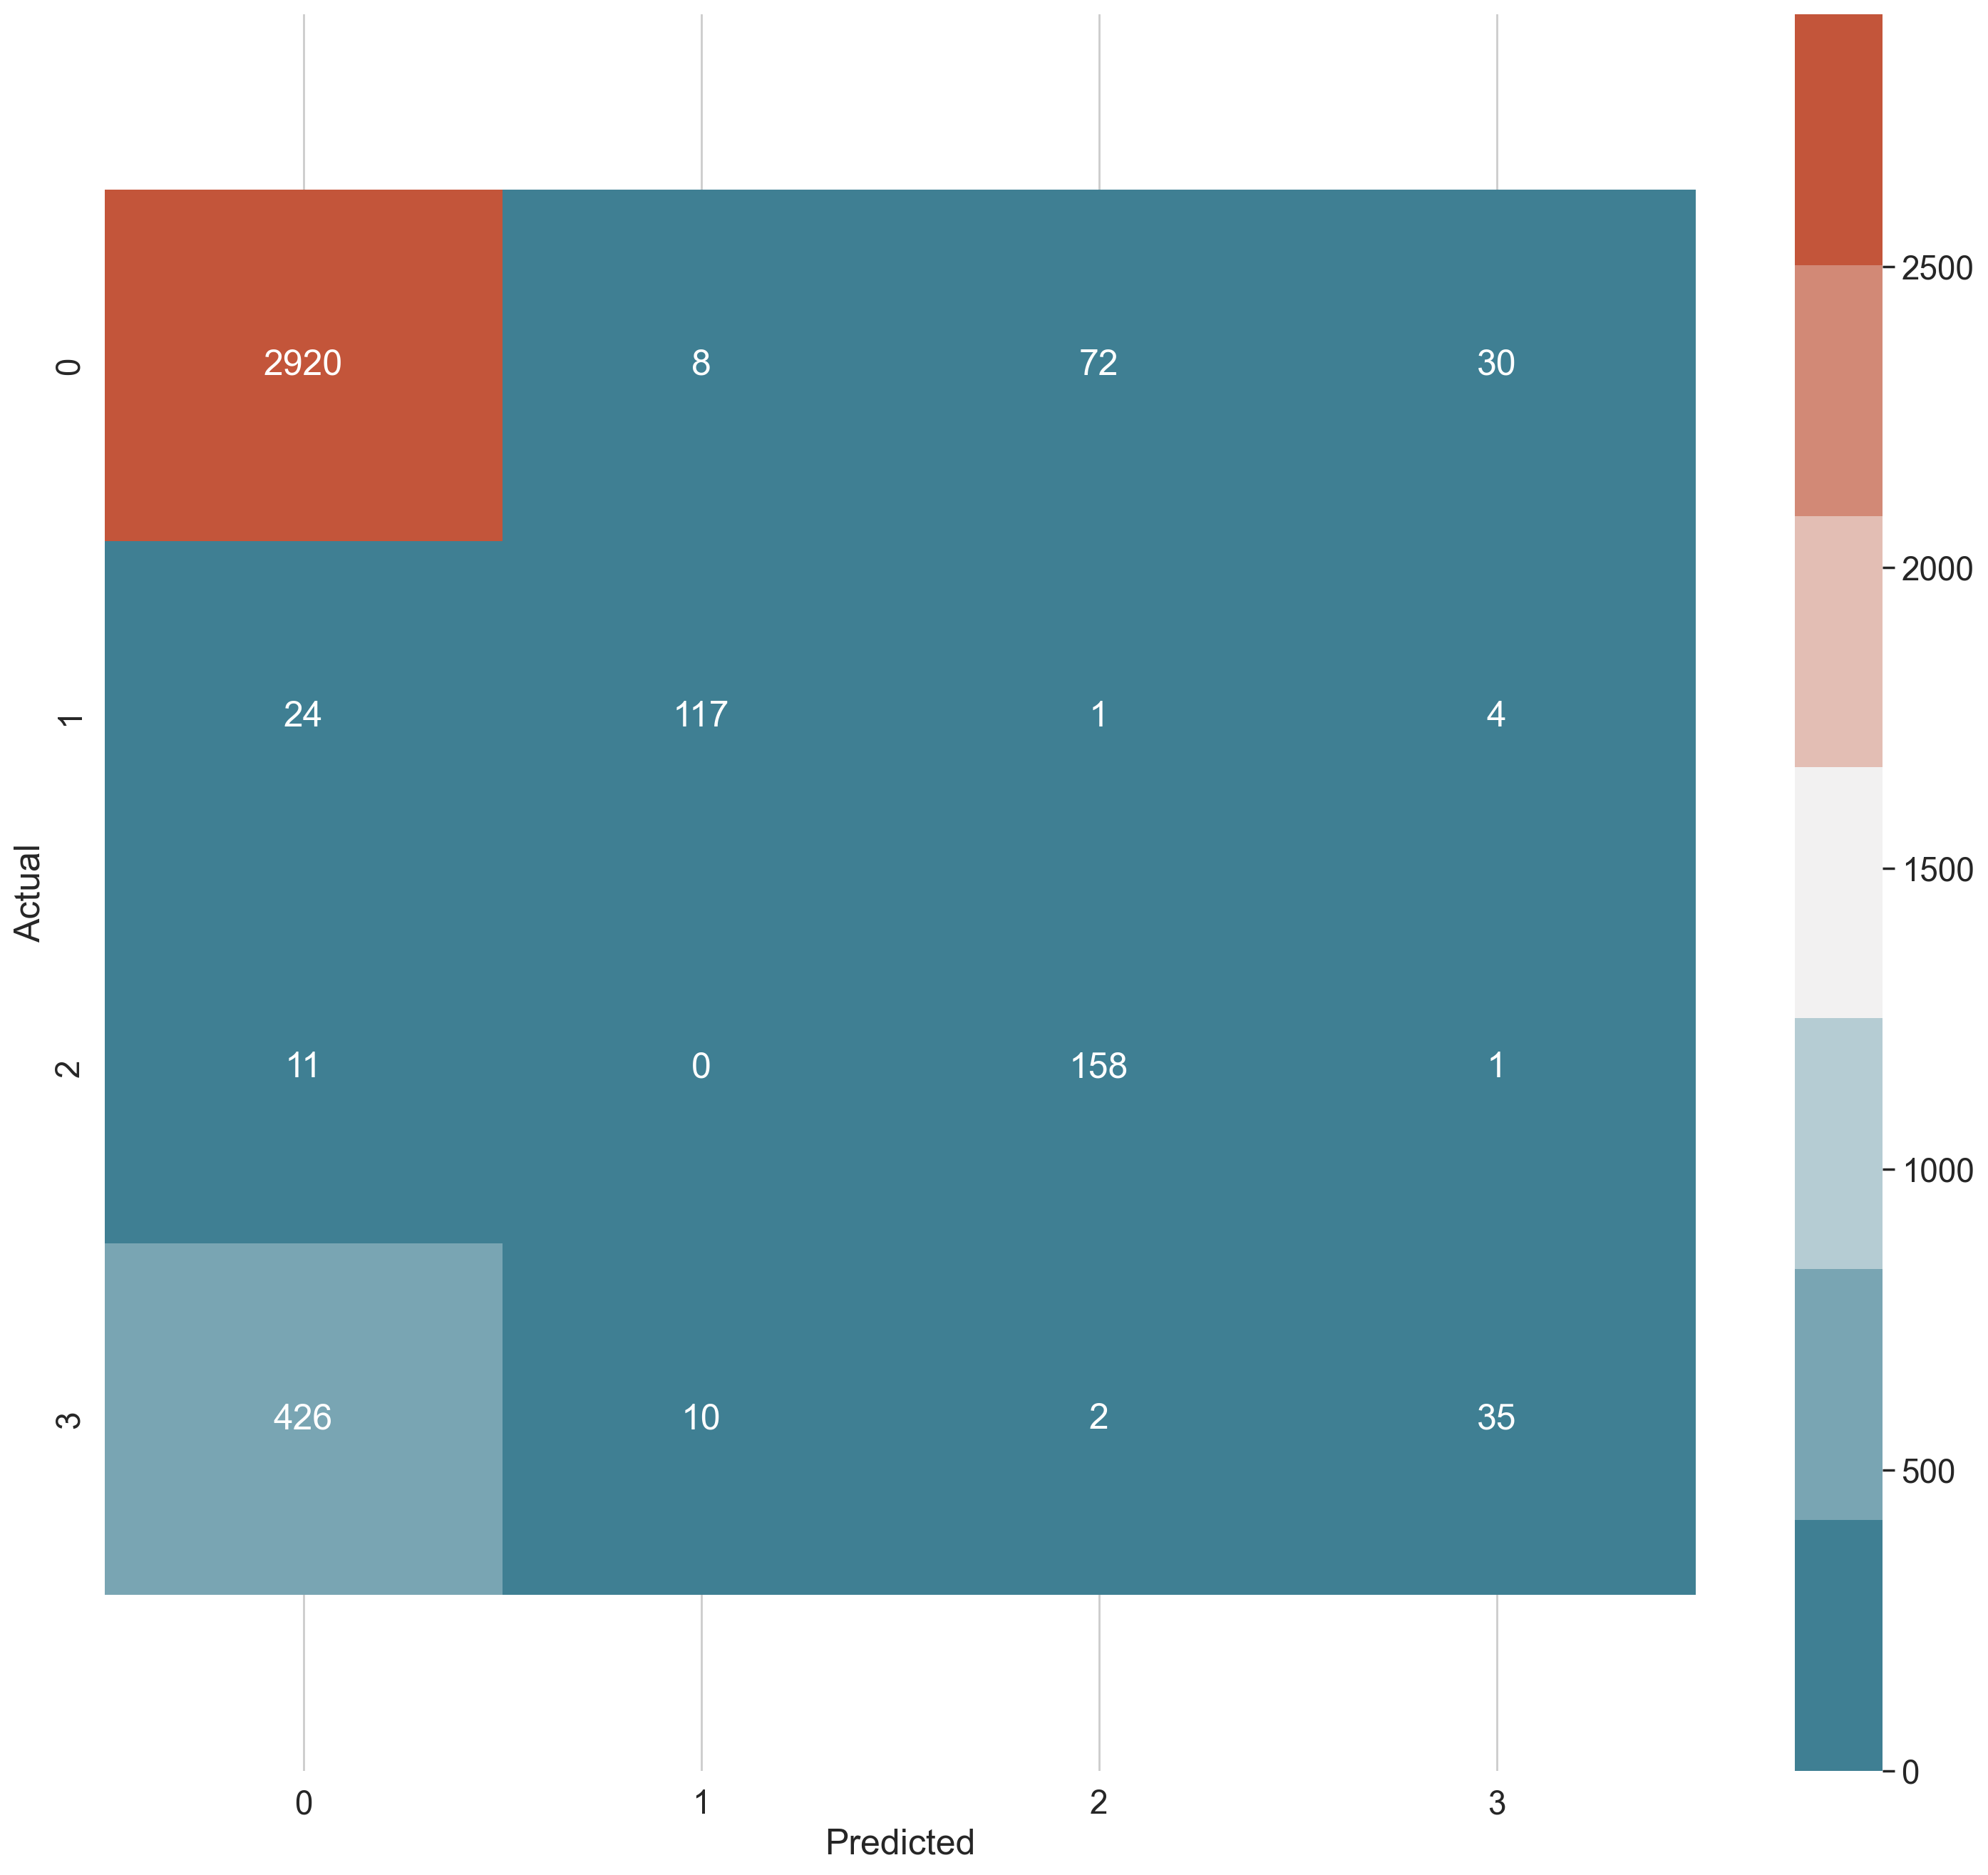

In [159]:
plot_cm(
  enc.inverse_transform(y_val),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)